# Data and Web Mining
## Kaggle ft Child Institute: problematic internet use 
alleneremo e metteremo a confronto due modelli. uno ad albero e uno basato su rete neurale.

In [59]:
import numpy as np 
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif # vedere correlazioni tra feature e label


# Preparazione dati
- rimuovere istanze con poche features  popolate
- onehot encoding 
- plot singole features
- features subset selection 
## importazione


In [69]:
# primo passo: leggere i dati, dividendo in features e label
data = pd.read_csv("../data/train.csv") # dataset intero

Y = data['sii']     # classe da predire

X = data.drop(columns=['id','sii'])     # features

# non ha senso lasciare righe in cui la label non si conosce. è supervised learning: ogni riga deve avere la sua classificazione
X = X[Y.notnull()]
Y = Y[Y.notnull()]
print("X shape", X.shape)
X

X shape (2736, 80)


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,...,0.0,2.0,2.0,1.0,22.0,Fall,41.0,58.0,Fall,2.0
3954,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,23.0,...,3.0,3.0,3.0,0.0,33.0,Summer,48.0,67.0,Summer,0.0
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,...,2.0,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,NaN,...,1.0,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0


## encoding
C'è la necessità di eliminare tutti i valori di tipo non numerico, rendendoli classi numeriche

In [70]:
X.dtypes


Basic_Demos-Enroll_Season                  object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-Season                                object
CGAS-CGAS_Score                           float64
                                           ...   
SDS-Season                                 object
SDS-SDS_Total_Raw                         float64
SDS-SDS_Total_T                           float64
PreInt_EduHx-Season                        object
PreInt_EduHx-computerinternet_hoursday    float64
Length: 80, dtype: object

Si può subito notare che le variabili non numeriche sono esclusivamente quelle stagionali. Operando su un albero, possiamo renderle numeriche usando un encoding ordinale, senza incorrere in problemi di scala e/o semantica.

In [71]:
# mapping stagioni
season_map = {
    # il mapping darà NaN quando incontra NaN, quindi viene gestito in automatico
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

# colonne che terminano in "-Season"
season_cols = [col for col in X.columns if col.endswith('Season')]

for col in season_cols:
    X[col] = X[col].map(season_map)

## pulizia
una cosa interessante da vedere è il numero di NaN per feature. In particolare, è interessante metterlo a confronto con le feature che più hanno correlazione con la classe da predirre. Infatti, dal momento che ogni feature in più aumenta il costo computazionale (in particolare, dovendo allenare una albero, ogni nodo richiede di calcolare ogni soglia su tutte le features), l'idea è di togliere fin da subito le feature che non hanno correlazione con la label e che non sono "utili" dal momento che sono NaN per molte righe

In [72]:
X.isnull().sum().sort_values(ascending=False)

PAQ_A-Season                    2373
PAQ_A-PAQ_A_Total               2373
Physical-Waist_Circumference    2253
Fitness_Endurance-Time_Mins     2008
Fitness_Endurance-Time_Sec      2008
                                ... 
Basic_Demos-Age                    0
Basic_Demos-Enroll_Season          0
Basic_Demos-Sex                    0
PCIAT-Season                       0
PCIAT-PCIAT_Total                  0
Length: 80, dtype: int64

ci sono colonne quasi interamente a null. Proseguiamo col vedere le correlazioni.
La Mutual Information (MI) misura "quanto sapere la feature aiuta a prevedere la classe" (più è alta, meglio è). Siccome i valori `NaN` non sono supportati, faccio un fill temporaneo con il valore -9999, che non appare mai 

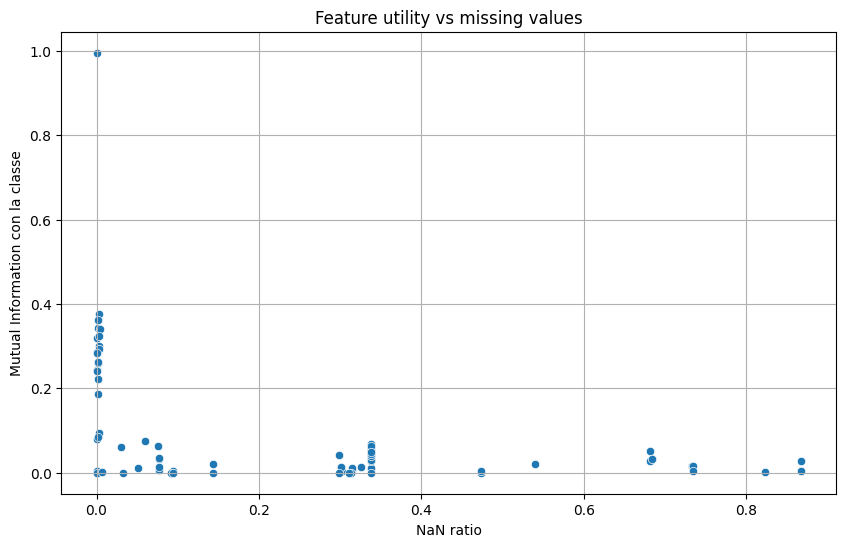

In [73]:

mi = mutual_info_classif(X.fillna(-9999), Y)  # fill temporaneo per gestire i NaN
mi_series = pd.Series(mi, index=X.columns)

# Percentuale di NaN
nan_ratio = X.isnull().mean()

# Scatterplot
plt.pyplot.figure(figsize=(10, 6))
sns.scatterplot(x=nan_ratio, y=mi_series)
plt.pyplot.xlabel("NaN ratio")
plt.pyplot.ylabel("Mutual Information con la classe")
plt.pyplot.title("Feature utility vs missing values")
plt.pyplot.grid(True)
plt.pyplot.show()


Ecco cosa volevamo ottenere! 
Osservazioni:
- Molti punti sono a sinistra (NaN ≈ 0), quindi ci sono pochissimi missing values
- ci sono alcune feature con MI >0.2
- Ci sono features con più della metà di valori assenti e mutual information prossima allo 0 -> sono features che non servono quasi a nulla. 
- Curioso invece che ci sia una feature con più del 99% di correlazione con la label.

Notare che Mutual Information e Feature Importance sono concetti simili ma non identici. Infatti l'MI valuta la correlazione tra la label e la singola feature, non tiene conto di correlazioni tra feature. La feature importance invece guarda su un modello ad albero quanto quella feature contribuisce alla predizione.
Entrambi i parametri soffrono dello stesso difetto (anche se in un certo senso "opposto"): 
- Se due feature sono molto correlate, la feature importance può "dividersi" tra loro, oppure una delle due può risultare meno importante perché il modello ha già "usato" l'informazione con l'altra. Di conseguenza non si può scartare a priori una feature basandosi solo sull'importance.
-  analogamente, la MI non tiene conto della combinazione tra le features. Può essere bassa per una singola feature, ma se prendessimo la combinazione di quella feature e di un'altra potrebbe salire molto. Un esempio banale è Y = A XOR B: A e B da sole non predicono assolutamente Y. però lo xor tra le due è predittore perfetto. se ne togliessimo una avremmo buttato via la soluzione

Ecco quindi che non possiamo a priori scartare le features con bassa MI, ma dobbiamo tenere in considerazione anche il numero di valori NaN.
 


In [81]:
# Trova le feature con mutual information pari a 1 rispetto alla label (solo per curiosità)
mi_1 = mi_series[mi_series > 0.9]
print("Feature con MI=1 rispetto alla label:")
print(mi_1)


Feature con MI=1 rispetto alla label:
PCIAT-PCIAT_Total    0.995807
dtype: float64


Ad ogni modo, possiamo eliminare le features con più del 60% di valori mancanti e mutual information prossima allo 0, perché arbitrariamente usiamo quelle come soglie per identificare le colonne non utili per il modello.

In [80]:
features_to_keep = mi_series[(mi_series > 0.1) & (nan_ratio < 0.4)].index
X = X[features_to_keep]
print("Features tenute:")
print(features_to_keep)

Features tenute:
Index(['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09',
       'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
       'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
       'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total'],
      dtype='object')


ora il dataset è pronto per essere diviso in train/test e per lavorarci sopra. La features importance si calcola con gli alberi e solo sul train, quindi è un passaggio che, se facciamo, va posticipato

In [ ]:
from sklearn.model_selection import train_test_split

# slip train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

# split train & val 
X_train,X_val , y_train, y_val = train_test_split(
    X_train,y_train,test_size = 0.2,random_state=42
)

bisogna creare la baseline. proverei due modi:
- provare a usare solo PCIAT_Total per fare la predizione. sembra avere una correlazione del 99%
- provare a predire sempre '0' (questo va fatto dopo aver fatto il grafico a barre della label).
si sceglie tra i due quello con la accuracy (o un'altra metrica di goodness) più alta. 


poi proverei a fare il plot delle singole features, se copilot/chatgpt mi aiutano sul come fare.

dopodiché si può partire. Secondo me come ti dicevo una buona idea è dividersi il lavoro. uno dei due fa la rete neurale e l'altro fa la random forest, così possiamo lavorare in parallelo (e a quel punto, su due branch diversi così evitiamo di farci casino a vicenda xD)

ad ogni modo ora devo andare a letto, ci risentiamo